In [2]:
import sqlite3
import pandas as pd
import matplotlib
from questions import verify_plot
import math
import os
import requests
import numpy as np

In [3]:
%matplotlib inline
pd.set_option('display.max_colwidth', None)
matplotlib.rcParams["font.size"] = 13

In [4]:
def download(filename, url):
    if os.path.isfile(filename) == True:
        return (str(filename) + " already exists!")
    else:
        r = requests.get(url)
        r.raise_for_status()
        text = r.text
        f = open(filename, "w")
        f.write(text)
        f.close()
        return (str(filename) + " created!")
    
def bar_plot(df, x, y):
    ax = df.plot.bar(x = x, y = y, color = 'k')
    ax.set_ylabel(y)
    ax.set_xlabel(x)
    return ax

def scatter_plot(df, x, y):
    ax = df.plot.scatter(x=x, y= y, color = 'k')
    return ax

def plot_horizontal_bar(df, x):
    df = df.set_index(x)
    ax = df.plot.barh()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.9))

def plot_pie(df, x, y, title=None):
    df = df.set_index(x)
    ax = df.plot.pie(y=y, legend=False)
    ax.set_ylabel(None)
    ax.set_title(title)

def get_regression_coeff(df, x, y):
    df["1"] = 1
    res = np.linalg.lstsq(df[[x, "1"]], df[y], rcond=None)
    coefficients = res[0]
    m = coefficients[0]
    b = coefficients[1]
    return (m, b)

def plot_regression_line(df, x, y):
    m = get_regression_coeff(df, x, y)[0]
    b = get_regression_coeff(df, x, y)[1]
    ax = df.plot.scatter(x= x, y= y, color = 'k')
    df['fit'] = m * df[x] + b
    return df.plot.line(ax = ax, x = x, y = 'fit', color = 'r')

download('QSranking.json', 'https://raw.githubusercontent.com/msyamkumar/cs220-s22-projects/main/p13/QSranking.json')
rankings = pd.read_json('QSranking.json')

conn = sqlite3.connect('rankings.db')
rankings.to_sql("rankings", conn, if_exists="replace", index=False)
rankings.head()


,rank,year,institution_name,country,academic_reputation,employer_reputation,faculty_student_score,citations_per_faculty,international_faculty,international_students,overall_score
0,1,2018,Massachusetts Institute Of Technology,United States,100.0,100.0,100.0,99.9,100.0,96.1,100.0
1,2,2018,Stanford University,United States,100.0,100.0,100.0,99.4,99.6,72.7,98.7
2,3,2018,Harvard University,United States,100.0,100.0,98.3,99.9,96.5,75.2,98.4
3,4,2018,California Institute Of Technology,United States,99.5,85.4,100.0,100.0,93.4,89.2,97.7
4,5,2018,University Of Cambridge,United Kingdom,100.0,100.0,100.0,78.3,97.4,97.7,95.6


In [5]:
#Q1: Which 10 institutions in Canada had the highest number of international students in 2020?

query = '''
select institution_name, international_students
from rankings
where Country = 'Canada' and Year = '2020'
order by international_students desc
limit 10

'''

top_10_canada = pd.read_sql(query, conn)
top_10_canada

,institution_name,international_students
0,Mcgill University,96.2
1,University Of Toronto,93.0
2,Simon Fraser University,91.5
3,University Of Waterloo,84.1
4,University Of Alberta,80.8
5,University Of British Columbia,79.3
6,Dalhousie University,73.4
7,Université De Montréal,61.8
8,University Of Calgary,61.2
9,University Of Ottawa,56.7


In [6]:
#Q2: Which 10 institutions in the United States had the highest reputation in 2019?


query = '''

select institution_name, academic_reputation + employer_reputation as reputation
from rankings
where Country = 'United States' and Year = '2019'
order by reputation desc, institution_name asc
limit 10


'''

top_10_usa = pd.read_sql(query, conn)
top_10_usa

,institution_name,reputation
0,Harvard University,200.0
1,Massachusetts Institute Of Technology,200.0
2,Stanford University,200.0
3,"University Of California, Berkeley",199.8
4,Yale University,199.6
5,"University Of California, Los Angeles",199.1
6,Columbia University,197.1
7,Princeton University,196.6
8,University Of Chicago,190.3
9,Cornell University,189.2


In [7]:
#Q3: Which 10 countries had the most institutions listed in the year 2020?

query = '''

select country, count(institution_name) as num_of_institutions
from rankings
where Year = '2020'
group by country
order by num_of_institutions desc, country asc



'''

top_country = pd.read_sql(query, conn)
top_10_country = top_country[:10]
top_10_country

,country,num_of_institutions
0,United States,74
1,United Kingdom,45
2,Germany,23
3,Australia,21
4,Canada,14
5,China,14
6,France,14
7,Japan,14
8,Netherlands,13
9,Russia,13


<AxesSubplot:xlabel='country', ylabel='num_of_institutions'>

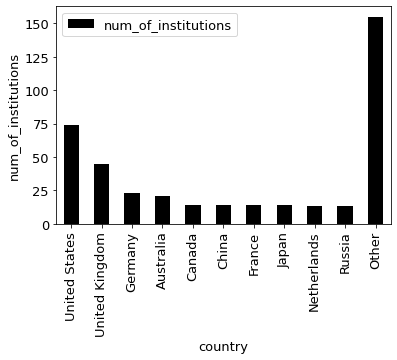

In [8]:
#Q4: Plot the data from Q3 as a bar chart, along with the sum of all other countries' institutions.

other = top_country["num_of_institutions"][10:].sum()
num_institutions = top_10_country.append({"country": "Other", "num_of_institutions": other }, ignore_index=True)
num_institutions


bar_plot(num_institutions, 'country', 'num_of_institutions')

In [9]:
#Q4.1 Verify your plot using verify_plot
verify_plot(num_institutions, 4)

True

In [10]:
#Q5: In 2019, what were the top 10 countries by total overall_score?

query = '''

select country, sum(overall_score) as total_score
from rankings
where Year = '2019'
group by country
order by total_score desc
limit 10



'''
top_total_score = pd.read_sql(query, conn)
top_total_score

,country,total_score
0,United States,4298.4
1,United Kingdom,2539.2
2,Germany,1098.2
3,Australia,1093.8
4,Japan,752.9
5,China,743.4
6,Canada,705.3
7,Netherlands,674.9
8,South Korea,612.8
9,France,595.2


<AxesSubplot:xlabel='country', ylabel='total_score'>

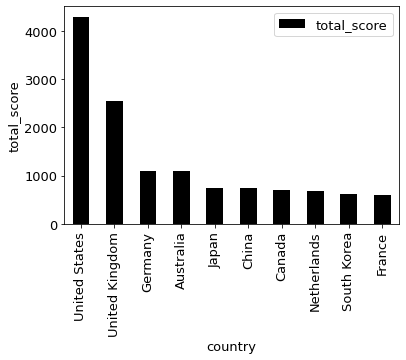

In [11]:
#Q6: Plot the data from Q5 as a bar chart.

bar_plot(top_total_score, 'country', 'total_score')

In [12]:
#Q6.1 Verify your plot using verify_plot
verify_plot(top_total_score, 6)

True

In [13]:
#Q7: In the year 2020, what are the top 10 universities in the US with the biggest international score?

query = '''

select institution_name, (international_faculty + international_students) as international_score
from rankings
where Year = '2020' and Country = 'United States'
order by international_score desc
limit 10



'''
top_international_score = pd.read_sql(query, conn)
top_international_score

,institution_name,international_score
0,Massachusetts Institute Of Technology,194.1
1,California Institute Of Technology,186.7
2,Carnegie Mellon University,183.5
3,Rice University,180.4
4,Northeastern University,179.1
5,Stanford University,167.5
6,Cornell University,166.1
7,Purdue University,158.2
8,University Of Rochester,157.9
9,University Of Chicago,151.2


<AxesSubplot:xlabel='citations_per_faculty', ylabel='overall_score'>

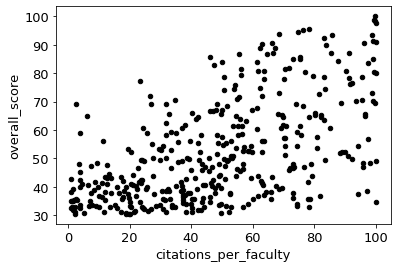

In [14]:
#Q8: In the year 2018, what is the relationship between citations_per_faculty and overall_score?

query = '''
select citations_per_faculty, overall_score
from rankings
where year = '2018'

'''
citations_score = pd.read_sql(query, conn)
scatter_plot(citations_score, 'citations_per_faculty', 'overall_score')

In [15]:
#Q8.1 Verify your plot using verify_plot
verify_plot(citations_score, 8)

True

<AxesSubplot:xlabel='academic_reputation', ylabel='employer_reputation'>

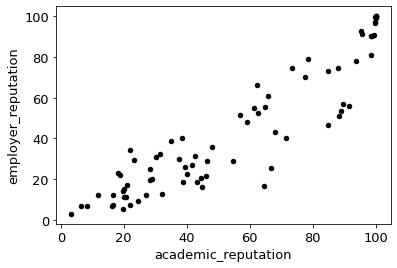

In [16]:
#Q9: In the year 2019, what is the relationship between academic_reputation and employer_reputation for institutions in the United States?
query = '''
select academic_reputation, employer_reputation
from rankings
where year = '2019' and country = 'United States'
'''
academic_score = pd.read_sql(query, conn)
scatter_plot(academic_score, 'academic_reputation', 'employer_reputation')

In [17]:
#Q9.1 Verify your plot using verify_plot
verify_plot(academic_score, 9)

True

<AxesSubplot:xlabel='international_students', ylabel='faculty_student_score'>

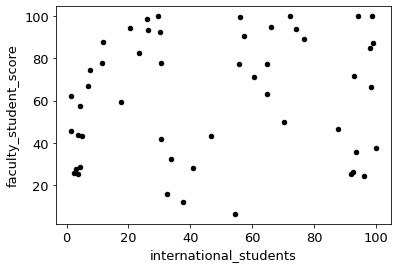

In [18]:
#Q10: In the year 2020, what is the relationship between international_students and faculty_student_score for the top ranked institution in each country?
query = '''
select international_students, faculty_student_score
from rankings
where year = '2020'
group by country
having MIN(rank)
'''
international_score = pd.read_sql(query, conn)
scatter_plot(international_score, 'international_students', 'faculty_student_score')

In [19]:
#Q10.1 Verify your plot using verify_plot
verify_plot(international_score, 10)

True

In [20]:
#Q11: Find the correlation between international_students and overall_score for institutions in the 'United Kingdom' that were ranked in the top 100 in the year 2020. Perform the same calculation for institutions in the 'United States'. What is the difference between these two correlations?
query = '''
select international_students, overall_score
from rankings
where country = 'United Kingdom' and year = '2020' and rank <= 100
order by rank asc

'''
uk_score = pd.read_sql(query, conn)

query = '''
select international_students, overall_score
from rankings
where country = 'United States' and year = '2020' and rank <= 100
order by rank asc

'''

us_score = pd.read_sql(query, conn)

us_corr = us_score.corr()
uk_corr = uk_score.corr()

uk_corr.loc['overall_score'].loc['international_students'] - us_corr.loc['overall_score'].loc['international_students']

0.18978846844574526

In [21]:
#Q12: In the year 2019, what is the correlation between citations_per_international and overall_score?

query = '''
select overall_score, (citations_per_faculty * international_faculty) / 100 as citations_per_international
from rankings
where year = '2019'


'''
citations_international_score = pd.read_sql(query, conn)
citations_international_score.corr().loc['overall_score'].loc['citations_per_international']



0.557397228343763

In [22]:
#Q13: In the year 2019, find the top 15 countries which have the highest total of citations_per_international.

query = '''
select country, sum((citations_per_faculty * international_faculty) / 100) as sum_intl_citations 
from rankings
where year = '2019'
group by country
order by sum_intl_citations desc
limit 15


'''
top_15_citations = pd.read_sql(query, conn)
top_15_citations

,country,sum_intl_citations
0,United States,2623.8207
1,United Kingdom,2347.1602
2,Australia,1255.5530
3,Netherlands,748.4268
4,Canada,724.5029
5,Switzerland,561.8790
6,China,482.2577
7,Germany,455.5466
8,Hong Kong,375.3032
9,New Zealand,327.3357


In [23]:
#Q14: In the year 2019, among the institutions ranked within the top 300, find the average of citations_per_international for each country.
query = '''
select country, AVG((citations_per_faculty * international_faculty) / 100) as avg_intl_citations
from rankings
where year = '2019' and rank <= 300
group by country
order by avg_intl_citations desc
'''

citations_international_avg = pd.read_sql(query, conn)
citations_international_avg

,country,avg_intl_citations
0,Singapore,80.150000
1,Switzerland,75.497000
2,Hong Kong,62.550533
3,Australia,61.362388
4,Netherlands,56.166733
5,New Zealand,53.226220
6,United Kingdom,52.889084
7,Canada,50.779723
8,Denmark,46.196200
9,Norway,46.083300


In [24]:
#Q15: Find the institution with the highest value for citations_per_international for each country in the year 2020.
query = '''
select country, institution_name, MAX((citations_per_faculty * international_faculty) / 100) as max_intl_citations
from rankings
where year = '2020'
group by country
HAVING `max_intl_citations` IS NOT NULL
order by max_intl_citations desc
'''

citations_international_max = pd.read_sql(query, conn)
citations_international_max

,country,institution_name,max_intl_citations
0,United States,Massachusetts Institute Of Technology,99.8000
1,Switzerland,Ecole Polytechnique Fédérale De Lausanne,98.9000
2,Netherlands,Eindhoven University Of Technology,95.4493
3,United Kingdom,London School Of Economics And Political Science,91.1000
4,Hong Kong,The Hong Kong University Of Science And Technology,89.5000
5,Singapore,Nanyang Technological University,88.8000
6,Australia,The University Of Western Australia,88.3000
7,Belgium,Katholieke Universiteit Leuven,76.7700
8,New Zealand,University Of Waikato,73.6434
9,Canada,Western University,72.3240


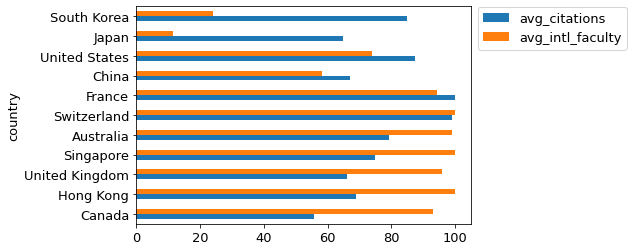

In [25]:
#Q16: Among the institutions ranked within the top 50, generate a barplot visualizing the average of citations_per_faculty and international_faculty for each country in the year 2018.
query = '''
select country, AVG(citations_per_faculty) as avg_citations, AVG(international_faculty) as avg_intl_faculty
from rankings
where year = '2018' and rank <= 50
group by country
order by (avg_citations - avg_intl_faculty)
'''
top_50_avgs = pd.read_sql(query, conn)
plot_horizontal_bar(top_50_avgs,'country')

In [26]:
#Q16.1: Verify your plot using verify_plot
verify_plot(top_50_avgs, 16)

True

<AxesSubplot:xlabel='overall_score', ylabel='rank'>

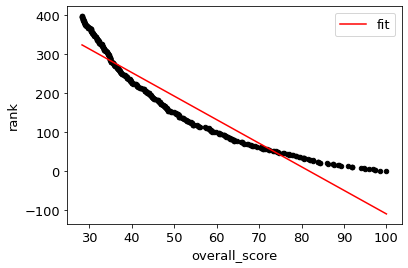

In [27]:
#Q17: What is the relationship between overall_score and rank for all the institutions in the year 2020?
query = '''
select overall_score, rank
from rankings
where year = '2020'
'''
overall_score_df = pd.read_sql(query, conn)

plot_regression_line(overall_score_df,'overall_score','rank')

In [28]:
#Q17.1: Verify your answer using verify_plot
verify_plot(overall_score_df, 17)

True

<AxesSubplot:xlabel='inverse_overall_score', ylabel='rank'>

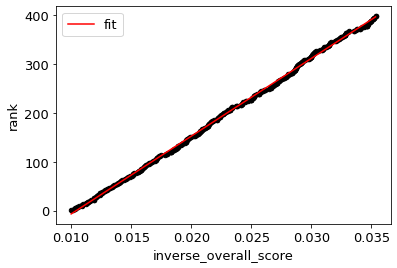

In [29]:
#Q18: What is the relationship between 1 / overall_score and rank for all the institutions in the year 2020?

query = '''
select  1 / overall_score as inverse_overall_score, rank
from rankings
where year = '2020'
'''
overall_inverted_score_df = pd.read_sql(query, conn)

plot_regression_line(overall_inverted_score_df,'inverse_overall_score','rank')

In [30]:
#Q18.1 Verify your plot using verify_plot

verify_plot(overall_inverted_score_df, 18)

True

In [31]:
#Q19: Use the regression line to estimate the rank of an institution with overall_score of 72.

m, b = get_regression_coeff(overall_inverted_score_df, 'inverse_overall_score','rank')
math.ceil(m / 72 + b)



56

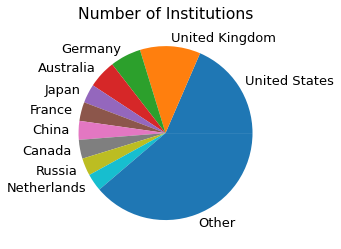

In [32]:
#Q20: What was the distribution of institutions in 2020 by country?

query = '''
select country, count(*) as num_of_institutions
from rankings
where year = '2020'
group by country
order by num_of_institutions desc
'''

distribution_country = pd.read_sql(query, conn)
top_10_distribution = distribution_country[:10]
other = distribution_country["num_of_institutions"][10:].sum()
top_11_distribution = top_10_distribution.append({"country": "Other", "num_of_institutions": other }, ignore_index=True)
plot_pie(top_11_distribution, 'country', 'num_of_institutions', title='Number of Institutions')


In [33]:
#Q20.1 Verify your plot using verify_plot
verify_plot(top_11_distribution, 20)

True

In [34]:
conn.close()